In [127]:
import numpy as np
import ahu_model
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn as sk
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.
%matplotlib inline

In [6]:
ahu_model.damper_pos_from_static(static=2)

0.4168000000000005

In [7]:
ahu_model.valve_pos_from_Tsa_static(45,1)

1

In [104]:
def graph_df(df, xlabel, ylabel, legend_label, title, size=(10,6), legend=True):
    plt.rcParams['figure.figsize'] = size
    p = sns.lineplot(data=df, legend=legend)
    p.set_xlabel(xlabel)
    p.set_ylabel(ylabel)
    p.set_title(title)
    if legend:
        plt.legend(title = legend_label)

In [50]:
# Objective: Two equipment: the AHU fan and the CHW pump are consuming electric power
# and the total power is needed to be minimized at any given time.
# Min(P_fan + P_pump)

# Control Variables: A typical AHU with VAV has two active setpoints that can be controlled: the static pressure setpoint
# (𝑃𝑠𝑡𝑎𝑡𝑖𝑐) and the supply air temperature setpoint (𝑇sa).

# Equality constraints: These models are provided in ahu_model.py.
# You need to give the required inputs. You can leave the optional inputs
# unchanged or adjust them to meet your needs.

# Damper position is a function of Pstatic
# As the static pressure drops, the damper has to be more open to allow
# the AHU to achieve the desired resistance. Use the damper_pos_from_static function

# Fan speed is a function of Pstatic
# As the static pressure increases, the fan speed increases to maintain the
# desired airflow with increased resistance in the AHU. Use the fan_speed_from_static function

# Fan power is a function of fan speed
# As the fan speed increases, the fan power consumption increases. Use the fan_power_from_speed function

# Valve position (as a percentage) is a function of Tsa and Pstatic
# As supply air temperature drops, more chilled water is required for cooling, leading
# to the further opening of the chilled water valve. Use the valve_pos_from_Tsa_static function

# Pump speed is a function of Tsa and Pstatic
# As supply air temperature drops, after a deflection point where
# the chilled water valve has been fully open, the chilled water pump
# speed will begin to increase. Use the pump_speed_from_Tsa_static function

# Pump power is a function of pump speed
# As pump speed increases, the pump power consumption increases.
# Use the pump_power_from_speed function

# Inequality constraints:
# Damper position < 1 to prevent insufficient cooling
# 0.15 < Fan Speed < 1 to protect the fan motor
# 0.3 <= Pump Speed < 1 to protect the pump motor
# 0.3 <= Pstatic <= 2.5 (allowable static pressure range)
# 55 <= Tsa <= 70 (allowable supply air temperature range)

In [51]:
# Calculate the damper position from static pressure, try different load conditions and store in dataframe
static_range = np.linspace(0.3,2.5,1000)
load_adj = np.linspace(-.25,.25,9)
damper_pos = np.zeros((len(static_range),len(load_adj)))
for i in range(len(static_range)):
    for j in range(len(load_adj)):
        val = ahu_model.damper_pos_from_static(static=static_range[i],load_adj=load_adj[j])
        # Using the constraint: Damper position < 1 to prevent insufficient cooling
        if 0 <= val < 1:
            damper_pos[i,j] = val
        else:
            damper_pos[i,j] = np.nan

# Convert to dataframe for plotting
df_damper_static = pd.DataFrame(damper_pos,index=static_range,columns=load_adj)

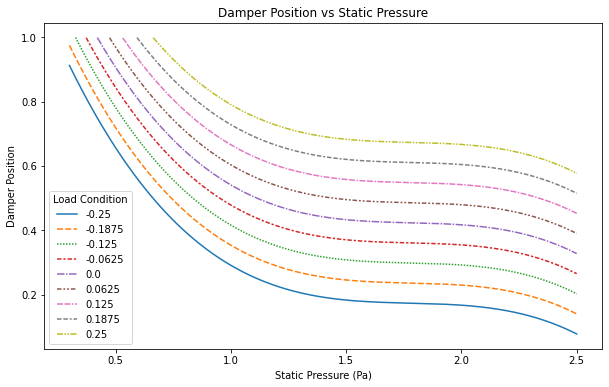

In [68]:
graph_df(df_damper_static, 'Static Pressure (Pa)', 'Damper Position', 'Load Condition', 'Damper Position vs Static Pressure')

In [64]:
# Calculate the fan speed from static pressure, try different fan adjustments and store in dataframe
static_range = np.linspace(0.3,2.5,1000)
fan_adj = np.linspace(.5,1.5,9)
fan_speed = np.zeros((len(static_range),len(fan_adj)))
for i in range(len(static_range)):
    for j in range(len(fan_adj)):
        val = ahu_model.fan_speed_from_static(static=static_range[i],fan_adj=fan_adj[j])
        # Using the constraint: 0.15 < Fan Speed < 1 to protect the fan motor
        if 0.15 <= val <= 1:
            fan_speed[i,j] = val
        else:
            fan_speed[i,j] = np.nan

df_fan_static = pd.DataFrame(fan_speed,index=static_range,columns=fan_adj)

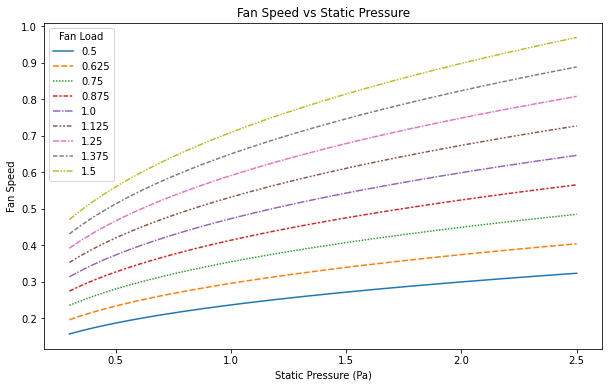

In [67]:
graph_df(df_fan_static, 'Static Pressure (Pa)', 'Fan Speed', 'Fan Load', 'Fan Speed vs Static Pressure')

In [93]:
# Calculate the fan power from fan speed
# Args:
# freq (float): fan speed in ratio, [0,1]
# hp (int, optional): horsepower of the fan. Defaults to 15, can change to other reasonable values.
# eff (float, optional): fan nominal efficiency. Defaults to 0.9, can change to other reasonable values.
default_hp = 15
default_eff = 0.9
hp_range = np.linspace(10,20,9) 
eff_range = np.linspace(0.5,1,9)
fan_speed_range = np.linspace(0.15,1,1000)
fan_power_hp_default = np.zeros((len(fan_speed_range),len(eff_range)))
for i in range(len(fan_speed_range)):
    for j in range(len(eff_range)):
        val = ahu_model.fan_power_from_speed(fan_speed_range[i],default_hp,eff_range[j])
        fan_power_hp_default[i,j] = val

fan_power_eff_default = np.zeros((len(fan_speed_range),len(hp_range)))
for i in range(len(fan_speed_range)):
    for j in range(len(hp_range)):
        val = ahu_model.fan_power_from_speed(fan_speed_range[i],hp_range[j],default_eff)
        fan_power_eff_default[i,j] = val

df_fan_power_speed_default_hp = pd.DataFrame(fan_power_hp_default,index=fan_speed_range,columns=eff_range)
df_fan_power_speed_default_eff = pd.DataFrame(fan_power_eff_default,index=fan_speed_range,columns=hp_range)


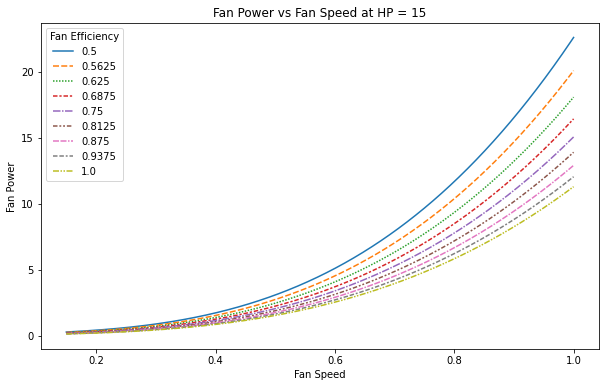

In [98]:
graph_df(df_fan_power_speed_default_hp, 'Fan Speed', 'Fan Power', 'Fan Efficiency', 'Fan Power vs Fan Speed at HP = 15')

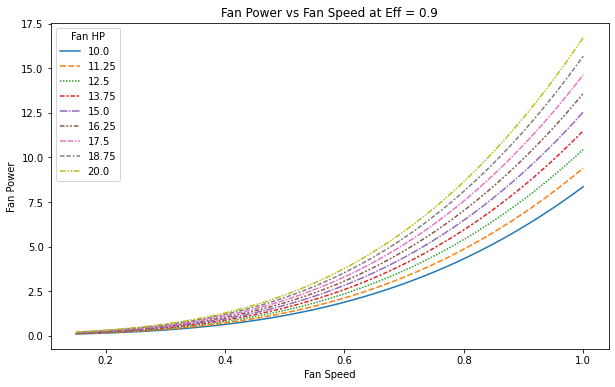

In [99]:
graph_df(df_fan_power_speed_default_eff, 'Fan Speed', 'Fan Power', 'Fan HP', 'Fan Power vs Fan Speed at Eff = 0.9')

In [102]:
# Calculate the valve position from Tsa and Pstatic
# Args:
# Tsa (float): supply air temperature
# Pstatic (float): static pressure in Pa
# Returns:
# valve_pos (float): valve position in ratio, [0,1]
tsa_range = np.linspace(55,70,1000)
static_range = np.linspace(0.3,2.5,100)
valve_pos = np.zeros((len(tsa_range),len(static_range)))
for i in range(len(tsa_range)):
    for j in range(len(static_range)):
        val = ahu_model.valve_pos_from_Tsa_static(tsa_range[i],static_range[j])
        # Using the constraint: 0 <= Valve Position <= 1
        if 0 <= val <= 1:
            valve_pos[i,j] = val
        else:
            valve_pos[i,j] = np.nan

df_valve_Tsa_static = pd.DataFrame(valve_pos,index=tsa_range,columns=static_range)


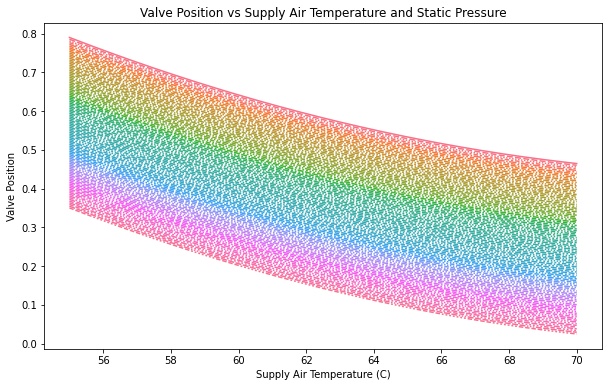

In [106]:
graph_df(df_valve_Tsa_static, 'Supply Air Temperature (C)', 'Valve Position', 'Static Pressure (Pa)', 'Valve Position vs Supply Air Temperature and Static Pressure', legend=False)

In [111]:
# Calculate the pump speed as a function of Tsa and Pstatic
# Args:
# Tsa (float): supply air temperature
# Pstatic (float): static pressure in Pa
# Returns:
# pump_speed (float): pump speed in ratio, [0,1]
tsa_range = np.linspace(55,70,1000)
static_range = np.linspace(0.3,2.5,50)
pump_speed = np.zeros((len(tsa_range),len(static_range)))
for i in range(len(tsa_range)):
    for j in range(len(static_range)):
        val = ahu_model.pump_speed_from_Tsa_static(tsa_range[i],static_range[j])
        # Using the constraint: 0 <= Pump Speed <= 1
        if .3 <= val <= 1:
            pump_speed[i,j] = val
        else:
            pump_speed[i,j] = np.nan

df_pump_speed_Tsa_static = pd.DataFrame(pump_speed,index=tsa_range,columns=static_range)


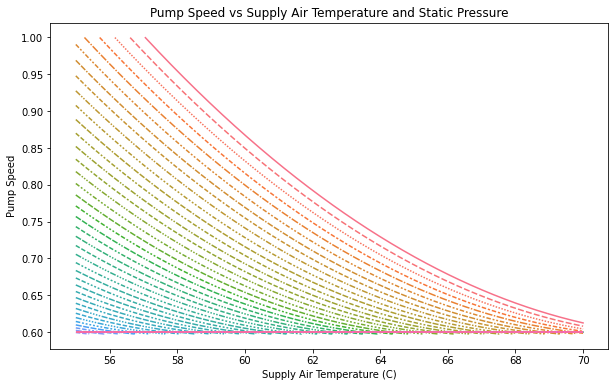

In [112]:
graph_df(df_pump_speed_Tsa_static, 'Supply Air Temperature (C)', 'Pump Speed', 'Static Pressure (Pa)', 'Pump Speed vs Supply Air Temperature and Static Pressure', legend=False)

In [113]:
# Calculate the pump power as a function of pump speed
default_hp = 25
default_eff = 0.9
hp_range = np.linspace(20,30,9)
eff_range = np.linspace(0.5,1,9)
pump_speed_range = np.linspace(0.3,1,1000)
pump_power_hp_default = np.zeros((len(pump_speed_range),len(eff_range)))
for i in range(len(pump_speed_range)):
    for j in range(len(eff_range)):
        val = ahu_model.pump_power_from_speed(pump_speed_range[i],default_hp,eff_range[j])
        pump_power_hp_default[i,j] = val

pump_power_eff_default = np.zeros((len(pump_speed_range),len(hp_range)))
for i in range(len(pump_speed_range)):
    for j in range(len(hp_range)):
        val = ahu_model.pump_power_from_speed(pump_speed_range[i],hp_range[j],default_eff)
        pump_power_eff_default[i,j] = val

df_pump_power_speed_default_hp = pd.DataFrame(pump_power_hp_default,index=pump_speed_range,columns=eff_range)
df_pump_power_speed_default_eff = pd.DataFrame(pump_power_eff_default,index=pump_speed_range,columns=hp_range)
        


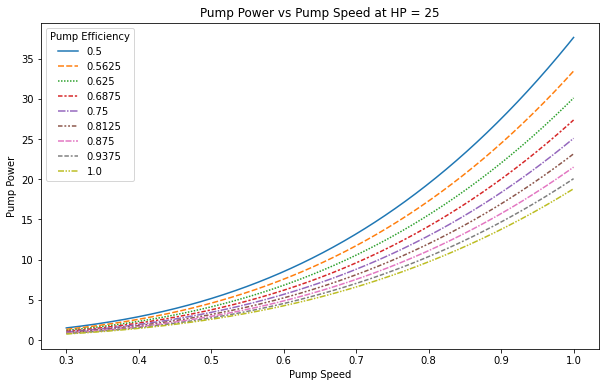

In [114]:
graph_df(df_pump_power_speed_default_hp, 'Pump Speed', 'Pump Power', 'Pump Efficiency', 'Pump Power vs Pump Speed at HP = 25')

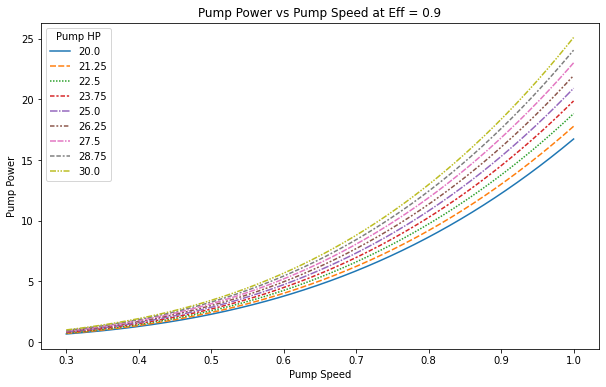

In [116]:
graph_df(df_pump_power_speed_default_eff, 'Pump Speed', 'Pump Power', 'Pump HP', 'Pump Power vs Pump Speed at Eff = 0.9')

In [117]:
# Explore the fan data
fan_data_df = pd.read_csv('fan_data.csv')

In [119]:
# Summary statistics
fan_data_df.describe()

,speed_ratio,kW
count,35040.000000,35040.000000
mean,7.995435,0.164545
std,15.727502,0.384702
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,58.610000,2.470000


In [ ]:
# Fit a cubic function to the data
X = fan_data_df['speed_ratio'].values.reshape(-1,)
y = fan_data_df['kW'].values.reshape(-1,)

fit = np.polyfit(X,y,3)
# plot the data and the fit

In [187]:
print(fit)

[ 1.37932912e-05 -3.20884322e-04  1.08347498e-02  2.75023071e-04]


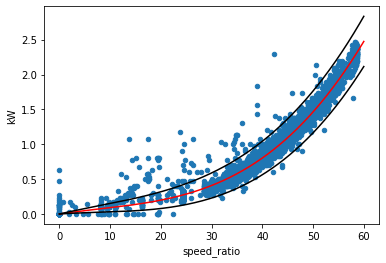

In [195]:
# Plot the speed_ratio vs kw
p = fan_data_df.plot(x='speed_ratio',y='kW',kind='scatter')
x = np.linspace(0,60,1000000)
y = fit[0]*x**3 + fit[1]*x**2 + fit[2]*x + fit[3]
y_lower = fit[0]*x**3 + fit[1]*x**2 + fit[2]*x + fit[3] - x*0.006
y_upper = fit[0]*x**3 + fit[1]*x**2 + fit[2]*x + fit[3] + x*0.006
p.plot(x,y, color='red')
p.plot(x,y_lower, color='black')
p.plot(x,y_upper, color='black')

In [197]:
def y_upper_func(x):
    return fit[0]*x**3 + fit[1]*x**2 + fit[2]*x + fit[3] + x*0.006

def y_lower_func(x):
    return fit[0]*x**3 + fit[1]*x**2 + fit[2]*x + fit[3] - x*0.006

In [198]:
# If speed_ratio > 0 and kw == 0, set outlier to True
fan_data_df['outlier'] = False
fan_data_df.loc[(fan_data_df['speed_ratio'] > 0) & (fan_data_df['kW'] == 0), 'outlier'] = True
# if the value kw is greater than y_upper, or less than y_lower, set outlier to True
fan_data_df.loc[(fan_data_df['kW'] > y_upper_func(fan_data_df['speed_ratio'])) | (fan_data_df['kW'] < y_lower_func(fan_data_df['speed_ratio'])), 'outlier'] = True


In [202]:
# get the outliers
outliers = fan_data_df[fan_data_df['outlier'] == True]
non_outliers = fan_data_df[fan_data_df['outlier'] == False]

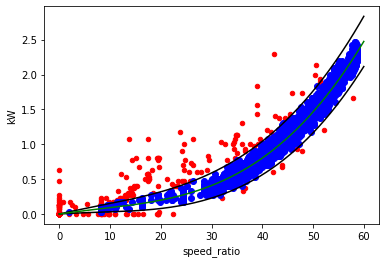

In [209]:
# plot the outliers
p = outliers.plot(x='speed_ratio',y='kW',kind='scatter', color='red')
# plot the non-outliers
p.scatter(non_outliers['speed_ratio'],non_outliers['kW'],color='blue')
p.plot(x,y_lower, color='black')
p.plot(x,y_upper, color='black')
p.plot(x,y, color='green')

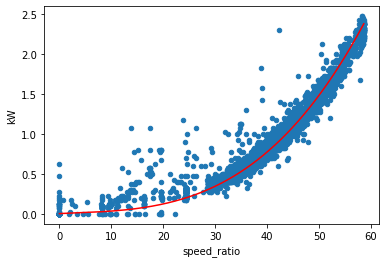

In [247]:
# Plot the fan power from speed using the ahu_model.fan_power_from_speed function on top of the data
p = fan_data_df.plot(x='speed_ratio',y='kW',kind='scatter')
max_speed = fan_data_df['speed_ratio'].max()
min_speed = fan_data_df['speed_ratio'].min()
x = np.linspace(min_speed,max_speed,1000)
# normalize the x values between 0 and 1
x_norm = (x - min_speed)/(max_speed - min_speed)
y = ahu_model.fan_power_from_speed(x_norm, 3, .95)
p.plot(x,y, color='red')

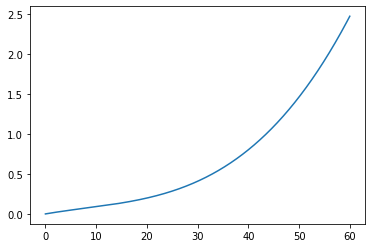

In [155]:
x = np.linspace(0,60,1000)
y = fit[0]*x**3 + fit[1]*x**2 + fit[2]*x + fit[3]
plt.plot(x,y)

In [142]:
# Fit a MLPRegressor to the data
fan_data_df.dropna(inplace=True)
fan_data_df.reset_index(drop=True,inplace=True)

X = fan_data_df['speed_ratio'].values.reshape(-1,1)
y = fan_data_df['kW'].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
regr = MLPRegressor(random_state=1, max_iter=1000).fit(X_train, y_train)
regr.predict(X_test[:2])
regr.score(X_test, y_test)

/Users/mitchellhermon/Development/PDCoreResearch/cr_challenge_files/.env/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9737923428071376

In [136]:
ddX[:5]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [ ]:
# We are given the fan speed ratio and the fan power in kW.
# The model we have goes as follows:
# chw_pump_power(kW) = f(pump_speed_ratio, pump_hp, pump_eff)
# pump_speed_ratio = f(supply_air_temp, static_pressure)
# chw_valve_pos = f(supply_air_temp, static_pressure)
# fan_power = f(fan_speed_ratio, fan_hp, fan_eff)
# fan_speed_ratio = f(static_pressure, fan_load_adjustment)
# damper_pos = f(static_pressure, load_adjustment)
# Build the equality constraints